# Merging Census and Health Data
Health data is saved as "health.csv" so change that if you have it labeled as something else.

To change variables extracted in census data, change codes under the "variables of interest section" and update the change name section.

To change variables extracted in census data, change "columns to keep" section.

In [1]:
pip install censusdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 34.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for censusdata: filename=CensusData-1.15.post1-py3-none-any.whl size=28205744 sha256=bf604a54e2b5bd571d5176ccb6bf6d8b7d37b4b67ed80a4b66f1f4760e15d970
  Stored in directory: /root/.cache/pip/wheels/54/5e/eb/518ccd7738e6b9b35d9fb3d226d45979066ec367ed26ad1369
Successfully built censusdata


In [2]:
import pandas as pd
import censusdata

## Census Data

In [3]:
# --- Variables of interest ---
variables = [
    'B19013_001E',  # Median income
    'B17001_002E',  # Poverty
    'B15003_017E',  # HS grad
    'B15003_022E',  # Bachelor's degree
    'B23025_005E',  # Unemployed
    'B01002_001E'   # Median age
]

# --- Valid state FIPS codes (50 states + DC) ---
valid_states = [
    '01','02','04','05','06','08','09','10','11','12','13','15','16','17','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35',
    '36','37','38','39','40','41','42','44','45','46','47','48','49','50','51','53',
    '54','55','56'
]

# --- Function to parse censusgeo objects ---
def split_geo(cgeo):
    codes = dict(cgeo.geo)
    name_parts = cgeo.name.split(", ")
    tract_name = name_parts[0]
    county_name = name_parts[1]
    state_name = name_parts[2]
    return pd.Series([
        codes.get('state'), codes.get('county'), codes.get('tract'),
        state_name, county_name, tract_name
    ])

# --- Download and process data for all states ---
all_data = []

for state in valid_states:
    print(f"Downloading data for state FIPS: {state}")
    data = censusdata.download(
        'acs5', 2015,
        censusdata.censusgeo([('state', state), ('county', '*'), ('tract', '*')]),
        variables
    )

    # Extract geo info
    geo_cols = data.index.to_series().apply(split_geo)
    geo_cols.columns = [
        'State_FIPS', 'County_FIPS', 'Tract_FIPS',
        'State_Name', 'County_Name', 'Tract_Name'
    ]

    # Combine geo info with data
    data_clean = pd.concat([geo_cols, data], axis=1).reset_index(drop=True)
    all_data.append(data_clean)

# --- Combine all states ---
census_df = pd.concat(all_data, ignore_index=True)

# --- Create 11-digit tract FIPS ---
census_df["Tract_FIPS_full"] = (
    census_df["State_FIPS"].astype(str).str.zfill(2) +
    census_df["County_FIPS"].astype(str).str.zfill(3) +
    census_df["Tract_FIPS"].astype(str).str.zfill(6)
)

#rename variables
census_df.rename(columns={
    'B19013_001E': 'Median_Income',
    'B17001_002E': 'Poverty',
    'B15003_017E': 'HS_Grad',
    'B15003_022E': 'Bachelors',
    'B23025_005E': 'Unemployed',
    'B01002_001E': 'Median_Age'
}, inplace=True)


print("ACS tract-level data ready with full 11-digit FIPS!")


ACS tract-level data ready with full 11-digit FIPS!


In [ ]:
census_df.head()

,State_FIPS,County_FIPS,Tract_FIPS,State_Name,County_Name,Tract_Name,Median_Income,Poverty,HS_Grad,Bachelors,Unemployed,Median_Age,Tract_FIPS_full
0,01,103,005109,Alabama,Morgan County,Census Tract 51.09,29644.0,1476,695,290,303,29.6,01103005109
1,01,103,005106,Alabama,Morgan County,Census Tract 51.06,35864.0,1186,899,924,293,43.3,01103005106
2,01,103,005107,Alabama,Morgan County,Census Tract 51.07,66739.0,137,632,805,126,43.5,01103005107
3,01,103,005108,Alabama,Morgan County,Census Tract 51.08,64632.0,566,589,535,166,45.8,01103005108
4,01,103,005701,Alabama,Morgan County,Census Tract 57.01,46306.0,571,295,205,52,38.4,01103005701


## Health Data

In [4]:
from google.colab import files

uploaded = files.upload()  # opens a file picker - make sure you names you file health.csv


Saving health.csv to health.csv


In [5]:
health_df = pd.read_csv("health.csv")

In [6]:
health_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,5275,28.0,"(22.7, 33.2)",19.9,"(18.8, 20.9)",...,"(81.5, 86.0)",17.3,"(15.3, 19.2)",38.9,"(37.2, 40.4)",4.0,"( 3.5, 4.5)",18.8,"(12.6, 25.6)",POINT (-118.224698433 34.0470512474)
1,CA,Pasadena,656000,6037462001,0656000-06037462001,3974,23.3,"(19.2, 27.8)",16.7,"(16.0, 17.5)",...,"(84.1, 87.5)",15.3,"(13.9, 16.8)",40.2,"(38.8, 41.5)",3.2,"( 2.9, 3.5)",18.1,"(13.7, 22.8)",POINT (-118.143832177 34.1633689905)
2,CA,Fullerton,628000,6059011504,0628000-06059011504,5473,11.7,"( 9.6, 14.5)",8.3,"( 7.9, 8.7)",...,"(75.4, 80.9)",8.5,"( 7.7, 9.5)",33.4,"(31.6, 35.1)",1.2,"( 1.1, 1.3)",11.9,"( 8.8, 16.0)",POINT (-117.883112998 33.8820402343)
3,TX,Longview,4843888,48183000401,4843888-48183000401,3371,19.3,"(16.8, 21.9)",21.1,"(20.2, 21.9)",...,"(76.5, 81.9)",11.8,"(10.8, 12.8)",34.9,"(33.4, 36.3)",2.7,"( 2.5, 3.0)",15.1,"(10.8, 20.4)",POINT (-94.7523262965 32.5544549842)
4,WI,Madison,5548000,55025002200,5548000-55025002200,4254,10.5,"( 8.7, 12.6)",23.3,"(21.9, 24.6)",...,"(83.4, 88.0)",11.3,"( 9.8, 12.7)",30.8,"(29.3, 32.2)",2.9,"( 2.5, 3.3)",12.9,"( 7.6, 19.8)",POINT (-89.3623704161 43.1211036947)


In [7]:
#extract the 11-digit tract FIPS after the dash
health_df["Tract_FIPS_full"] = health_df["Place_TractID"].str.split("-").str[-1]

In [8]:
health_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,Tract_FIPS_full
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,5275,28.0,"(22.7, 33.2)",19.9,"(18.8, 20.9)",...,17.3,"(15.3, 19.2)",38.9,"(37.2, 40.4)",4.0,"( 3.5, 4.5)",18.8,"(12.6, 25.6)",POINT (-118.224698433 34.0470512474),06037206032
1,CA,Pasadena,656000,6037462001,0656000-06037462001,3974,23.3,"(19.2, 27.8)",16.7,"(16.0, 17.5)",...,15.3,"(13.9, 16.8)",40.2,"(38.8, 41.5)",3.2,"( 2.9, 3.5)",18.1,"(13.7, 22.8)",POINT (-118.143832177 34.1633689905),06037462001
2,CA,Fullerton,628000,6059011504,0628000-06059011504,5473,11.7,"( 9.6, 14.5)",8.3,"( 7.9, 8.7)",...,8.5,"( 7.7, 9.5)",33.4,"(31.6, 35.1)",1.2,"( 1.1, 1.3)",11.9,"( 8.8, 16.0)",POINT (-117.883112998 33.8820402343),06059011504
3,TX,Longview,4843888,48183000401,4843888-48183000401,3371,19.3,"(16.8, 21.9)",21.1,"(20.2, 21.9)",...,11.8,"(10.8, 12.8)",34.9,"(33.4, 36.3)",2.7,"( 2.5, 3.0)",15.1,"(10.8, 20.4)",POINT (-94.7523262965 32.5544549842),48183000401
4,WI,Madison,5548000,55025002200,5548000-55025002200,4254,10.5,"( 8.7, 12.6)",23.3,"(21.9, 24.6)",...,11.3,"( 9.8, 12.7)",30.8,"(29.3, 32.2)",2.9,"( 2.5, 3.3)",12.9,"( 7.6, 19.8)",POINT (-89.3623704161 43.1211036947),55025002200


In [9]:
health_df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Population2010', 'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI',
       'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI', 'BINGE_CrudePrev',
       'BINGE_Crude95CI', 'BPHIGH_CrudePrev', 'BPHIGH_Crude95CI',
       'BPMED_CrudePrev', 'BPMED_Crude95CI', 'CANCER_CrudePrev',
       'CANCER_Crude95CI', 'CASTHMA_CrudePrev', 'CASTHMA_Crude95CI',
       'CHD_CrudePrev', 'CHD_Crude95CI', 'CHECKUP_CrudePrev',
       'CHECKUP_Crude95CI', 'CHOLSCREEN_CrudePrev', 'CHOLSCREEN_Crude95CI',
       'COLON_SCREEN_CrudePrev', 'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev',
       'COPD_Crude95CI', 'COREM_CrudePrev', 'COREM_Crude95CI',
       'COREW_CrudePrev', 'COREW_Crude95CI', 'CSMOKING_CrudePrev',
       'CSMOKING_Crude95CI', 'DENTAL_CrudePrev', 'DENTAL_Crude95CI',
       'DIABETES_CrudePrev', 'DIABETES_Crude95CI', 'HIGHCHOL_CrudePrev',
       'HIGHCHOL_Crude95CI', 'KIDNEY_CrudePrev', 'KIDNEY_Crude95CI',
       'LPA_CrudePrev', 'LPA_

In [10]:
#filter for columns we want
# we can add more: check the excel sheet
columns_to_keep = [
    "StateAbbr",
    "PlaceName",
    "PlaceFIPS",
    "TractFIPS",
    "Place_TractID",
    "Tract_FIPS_full",
    "Population2010",
    "OBESITY_CrudePrev",
    "DIABETES_CrudePrev",
    "HIGHCHOL_CrudePrev",
    "BPHIGH_CrudePrev",
    "STROKE_CrudePrev",
    "SLEEP_CrudePrev",
    "MHLTH_CrudePrev",
    "CASTHMA_CrudePrev",
    "CHD_CrudePrev",
    "CSMOKING_CrudePrev"
]

# Filter merged dataframe
health_filtered = health_df[columns_to_keep]

## Merge

In [11]:
merged_df = health_filtered.merge(census_df, on="Tract_FIPS_full", how="inner")

In [12]:
merged_df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Tract_FIPS_full', 'Population2010', 'OBESITY_CrudePrev',
       'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev', 'BPHIGH_CrudePrev',
       'STROKE_CrudePrev', 'SLEEP_CrudePrev', 'MHLTH_CrudePrev',
       'CASTHMA_CrudePrev', 'CHD_CrudePrev', 'CSMOKING_CrudePrev',
       'State_FIPS', 'County_FIPS', 'Tract_FIPS', 'State_Name', 'County_Name',
       'Tract_Name', 'Median_Income', 'Poverty', 'HS_Grad', 'Bachelors',
       'Unemployed', 'Median_Age'],
      dtype='object')

In [13]:
merged_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Population2010,OBESITY_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,...,Tract_FIPS,State_Name,County_Name,Tract_Name,Median_Income,Poverty,HS_Grad,Bachelors,Unemployed,Median_Age
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,06037206032,5275,29.5,15.5,38.3,...,206032,California,Los Angeles County,Census Tract 2060.32,26094.0,1829,675,309,185,29.5
1,CA,Pasadena,656000,6037462001,0656000-06037462001,06037462001,3974,32.0,11.6,31.8,...,462001,California,Los Angeles County,Census Tract 4620.01,40192.0,947,475,367,167,29.4
2,CA,Fullerton,628000,6059011504,0628000-06059011504,06059011504,5473,18.7,4.6,21.1,...,011504,California,Orange County,Census Tract 115.04,31793.0,1740,225,873,379,22.8
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,9.2,33.9,...,000401,Texas,Gregg County,Census Tract 4.01,52846.0,454,637,201,123,34.0
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,8.7,34.6,...,002200,Wisconsin,Dane County,Census Tract 22,42621.0,491,523,594,339,42.1


In [14]:
merged_df.shape

(27209, 29)

##Wrangling/ Cleaning


In [15]:
# Rename Crude Columns
merged_df = merged_df.rename(columns={
    "OBESITY_CrudePrev": "Obesity_Pct",
    "DIABETES_CrudePrev": "Diabetes_Pct",
    "HIGHCHOL_CrudePrev": "HighChol_Pct",
    "BPHIGH_CrudePrev": "HighBP_Pct",
    "STROKE_CrudePrev": "Stroke_Pct",
    "SLEEP_CrudePrev": "Sleep_Pct",
    "MHLTH_CrudePrev": "MentalHealth_Pct",
    "CASTHMA_CrudePrev": "Asthma_Pct",
    "CHD_CrudePrev": "HeartDisease_Pct",
    "CSMOKING_CrudePrev": "Smoking_Pct"
})


In [16]:
merged_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Population2010,Obesity_Pct,Diabetes_Pct,HighChol_Pct,...,Tract_FIPS,State_Name,County_Name,Tract_Name,Median_Income,Poverty,HS_Grad,Bachelors,Unemployed,Median_Age
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,06037206032,5275,29.5,15.5,38.3,...,206032,California,Los Angeles County,Census Tract 2060.32,26094.0,1829,675,309,185,29.5
1,CA,Pasadena,656000,6037462001,0656000-06037462001,06037462001,3974,32.0,11.6,31.8,...,462001,California,Los Angeles County,Census Tract 4620.01,40192.0,947,475,367,167,29.4
2,CA,Fullerton,628000,6059011504,0628000-06059011504,06059011504,5473,18.7,4.6,21.1,...,011504,California,Orange County,Census Tract 115.04,31793.0,1740,225,873,379,22.8
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,9.2,33.9,...,000401,Texas,Gregg County,Census Tract 4.01,52846.0,454,637,201,123,34.0
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,8.7,34.6,...,002200,Wisconsin,Dane County,Census Tract 22,42621.0,491,523,594,339,42.1


In [17]:
merged_df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Tract_FIPS_full', 'Population2010', 'Obesity_Pct', 'Diabetes_Pct',
       'HighChol_Pct', 'HighBP_Pct', 'Stroke_Pct', 'Sleep_Pct',
       'MentalHealth_Pct', 'Asthma_Pct', 'HeartDisease_Pct', 'Smoking_Pct',
       'State_FIPS', 'County_FIPS', 'Tract_FIPS', 'State_Name', 'County_Name',
       'Tract_Name', 'Median_Income', 'Poverty', 'HS_Grad', 'Bachelors',
       'Unemployed', 'Median_Age'],
      dtype='object')

In [18]:
merged_df.shape

(27209, 29)

In [19]:
# Make new variables with raw count
# Also I am using teh 2010 populations povided with the dataset not the Tract data
for col in ["Obesity_Pct", "Diabetes_Pct", "HighChol_Pct", "HighBP_Pct",
            "Stroke_Pct", "Sleep_Pct", "MentalHealth_Pct",
            "Asthma_Pct", "HeartDisease_Pct", "Smoking_Pct"]:
    new_col = col.replace("_Pct", "_Count")
    merged_df[new_col] = round((merged_df[col] / 100) * merged_df["Population2010"])


In [20]:
# Check the raw numbers
merged_df[["Population2010", "Obesity_Pct", "Obesity_Count"]].head()


,Population2010,Obesity_Pct,Obesity_Count
0,5275,29.5,1556.0
1,3974,32.0,1272.0
2,5473,18.7,1023.0
3,3371,33.9,1143.0
4,4254,29.5,1255.0


In [21]:
merged_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Population2010,Obesity_Pct,Diabetes_Pct,HighChol_Pct,...,Obesity_Count,Diabetes_Count,HighChol_Count,HighBP_Count,Stroke_Count,Sleep_Count,MentalHealth_Count,Asthma_Count,HeartDisease_Count,Smoking_Count
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,06037206032,5275,29.5,15.5,38.3,...,1556.0,818.0,2020.0,1672.0,211.0,2052.0,791.0,448.0,364.0,823.0
1,CA,Pasadena,656000,6037462001,0656000-06037462001,06037462001,3974,32.0,11.6,31.8,...,1272.0,461.0,1264.0,1077.0,127.0,1598.0,624.0,374.0,191.0,707.0
2,CA,Fullerton,628000,6059011504,0628000-06059011504,06059011504,5473,18.7,4.6,21.1,...,1023.0,252.0,1155.0,744.0,66.0,1828.0,772.0,504.0,115.0,728.0
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,9.2,33.9,...,1143.0,310.0,1143.0,957.0,91.0,1176.0,455.0,314.0,182.0,691.0
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,8.7,34.6,...,1255.0,370.0,1472.0,1187.0,123.0,1310.0,502.0,391.0,255.0,706.0


In [ ]:
merged_df.shape
merged_df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Tract_FIPS_full', 'Population2010', 'Obesity_Pct', 'Diabetes_Pct',
       'HighChol_Pct', 'HighBP_Pct', 'Stroke_Pct', 'Sleep_Pct',
       'MentalHealth_Pct', 'Asthma_Pct', 'HeartDisease_Pct', 'Smoking_Pct',
       'State_FIPS', 'County_FIPS', 'Tract_FIPS', 'State_Name', 'County_Name',
       'Tract_Name', 'Median_Income', 'Poverty', 'HS_Grad', 'Bachelors',
       'Unemployed', 'Median_Age', 'Obesity_Count', 'Diabetes_Count',
       'HighChol_Count', 'HighBP_Count', 'Stroke_Count', 'Sleep_Count',
       'MentalHealth_Count', 'Asthma_Count', 'HeartDisease_Count',
       'Smoking_Count'],
      dtype='object')

In [22]:
# Check % of missing data
merged_df.isna().mean().sort_values(ascending=False).head(10)


,0
Median_Income,0.001323
PlaceName,0.000000
StateAbbr,0.000000
TractFIPS,0.000000
Place_TractID,0.000000
Tract_FIPS_full,0.000000
PlaceFIPS,0.000000
Population2010,0.000000
Obesity_Pct,0.000000
HighChol_Pct,0.000000


##Final measurements

In [23]:
# Shape
merged_df = merged_df.dropna(subset=["Median_Income"])
merged_df.shape


(27173, 39)

In [24]:
# Columns
merged_df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Tract_FIPS_full', 'Population2010', 'Obesity_Pct', 'Diabetes_Pct',
       'HighChol_Pct', 'HighBP_Pct', 'Stroke_Pct', 'Sleep_Pct',
       'MentalHealth_Pct', 'Asthma_Pct', 'HeartDisease_Pct', 'Smoking_Pct',
       'State_FIPS', 'County_FIPS', 'Tract_FIPS', 'State_Name', 'County_Name',
       'Tract_Name', 'Median_Income', 'Poverty', 'HS_Grad', 'Bachelors',
       'Unemployed', 'Median_Age', 'Obesity_Count', 'Diabetes_Count',
       'HighChol_Count', 'HighBP_Count', 'Stroke_Count', 'Sleep_Count',
       'MentalHealth_Count', 'Asthma_Count', 'HeartDisease_Count',
       'Smoking_Count'],
      dtype='object')

In [25]:
# Head
merged_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Population2010,Obesity_Pct,Diabetes_Pct,HighChol_Pct,...,Obesity_Count,Diabetes_Count,HighChol_Count,HighBP_Count,Stroke_Count,Sleep_Count,MentalHealth_Count,Asthma_Count,HeartDisease_Count,Smoking_Count
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,06037206032,5275,29.5,15.5,38.3,...,1556.0,818.0,2020.0,1672.0,211.0,2052.0,791.0,448.0,364.0,823.0
1,CA,Pasadena,656000,6037462001,0656000-06037462001,06037462001,3974,32.0,11.6,31.8,...,1272.0,461.0,1264.0,1077.0,127.0,1598.0,624.0,374.0,191.0,707.0
2,CA,Fullerton,628000,6059011504,0628000-06059011504,06059011504,5473,18.7,4.6,21.1,...,1023.0,252.0,1155.0,744.0,66.0,1828.0,772.0,504.0,115.0,728.0
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,9.2,33.9,...,1143.0,310.0,1143.0,957.0,91.0,1176.0,455.0,314.0,182.0,691.0
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,8.7,34.6,...,1255.0,370.0,1472.0,1187.0,123.0,1310.0,502.0,391.0,255.0,706.0


In [26]:
merged_df.to_csv("merged_health_census_clean.csv", index=False)


In [27]:
from google.colab import drive
drive.mount('/content/drive')

# Save into your Drive
merged_df.to_csv("/content/drive/MyDrive/merged_health_census_clean.csv", index=False)


Mounted at /content/drive


### **Beginning EDA here**

In [34]:
#Beginning with descriptive stats for all numerical variables (nationwide basically)

numeric_summary = merged_df[['Obesity_Pct', 'Diabetes_Pct',
       'HighChol_Pct', 'HighBP_Pct', 'Stroke_Pct', 'Sleep_Pct',
       'MentalHealth_Pct', 'Asthma_Pct', 'HeartDisease_Pct', 'Smoking_Pct']].describe()

print(numeric_summary)


        Obesity_Pct  Diabetes_Pct  HighChol_Pct    HighBP_Pct    Stroke_Pct  \
count  27173.000000  27173.000000  27173.000000  27173.000000  27173.000000   
mean      30.090027     10.815155     34.601170     30.519884      3.233187   
std        8.228430      4.280811      5.170335      8.293445      1.536581   
min        9.100000      0.700000      7.400000      4.900000      0.200000   
25%       24.000000      7.900000     31.900000     25.300000      2.200000   
50%       29.100000     10.000000     34.900000     29.300000      2.900000   
75%       35.100000     13.000000     37.800000     34.500000      3.800000   
max       57.500000     40.700000     57.700000     71.000000     21.400000   

          Sleep_Pct  MentalHealth_Pct    Asthma_Pct  HeartDisease_Pct  \
count  27173.000000      27173.000000  27173.000000      27173.000000   
mean      36.715011         13.105016      9.696187          5.812862   
std        5.956682          3.404568      1.858265          2.082439

**Interpreting the Descriptive Stats**

Seems like Obesity, High Cholesterol, High BP, and insufficient sleep are the three health issues with the highest average percentages across tracts.

Additionally, we see the standard deviations of obesity, high blood pressure, sleep, and smoking are high. This means there is a significant inequality between tracts which is something we definitely want to investigate thru socioeconomic factors. Variables like Stroke, Asthma, and Heart disease have smaller standard deviations so that would indicate most tracts have an obesity rate close to the averages displayed.

We can also attribute the "minimum" values as the "best case scenarios" in our tract data to determine which tracts might be the healthiest or with the fewest negative socioeconomic indicators. Likewise, the maximum values would be the "worst case scenarios".

Potential outliers: If there is a large gap between the 75th percentile and the max values (Basically all the variables demonstrate this)

When comparing the medians (50%) to the means, a difference means the data may be skewed one way. To determine this, I calculated a skewness coefficient for each variable.

In [38]:
#calculating the skewness coefficient for each variables

columns = ['Obesity_Pct', 'Diabetes_Pct',
       'HighChol_Pct', 'HighBP_Pct', 'Stroke_Pct', 'Sleep_Pct',
       'MentalHealth_Pct', 'Asthma_Pct', 'HeartDisease_Pct', 'Smoking_Pct']
skewness = merged_df[columns].skew()
print(skewness)

Obesity_Pct         0.508315
Diabetes_Pct        0.924898
HighChol_Pct       -0.645851
HighBP_Pct          0.695013
Stroke_Pct          1.488858
Sleep_Pct           0.378641
MentalHealth_Pct    0.504329
Asthma_Pct          0.839554
HeartDisease_Pct    0.981093
Smoking_Pct         0.644544
dtype: float64


**Interpeting the skew**


*   Pretty symmetrical: Obesity, Sleep, Mental Health
*   Moderately Skewed: Diabetes, High Chol, High BP, Asthma, Heart Disease, Smoking
* Highly Skewed: Stroke

**   Outlier tracts for stroke are points of interesst for us


Negative Values mean left skew, positive mean right

Also, I am not entirely sure about the thresholds for the skewness coefficients, so look at the histograms more for skewness than these numbers. But they can still be useful for our final report.




In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
#Visualize distributions

#obesity
sns.histplot(data=merged_df, x='Obesity_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Obesity Percentage Across Census Tracts')
plt.show()

#diabetes
sns.histplot(data=merged_df, x='Diabetes_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Diabetes Percentage Across Census Tracts')
plt.show()

#stroke
sns.histplot(data=merged_df, x='Stroke_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Stroke Percentage Across Census Tracts')
plt.show()

#high chol
sns.histplot(data=merged_df, x='HighChol_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of High Cholesterol Percentage Across Census Tracts')
plt.show()

#high BP
sns.histplot(data=merged_df, x='HighBP_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of High BP Percentage Across Census Tracts')
plt.show()

#sleep
sns.histplot(data=merged_df, x='Sleep_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Insufficient Sleep Percentage Across Census Tracts')
plt.show()

#mental health
sns.histplot(data=merged_df, x='MentalHealth_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Mental Health Percentage Across Census Tracts')
plt.show()

#asthma
sns.histplot(data=merged_df, x='Asthma_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Asthma Percentage Across Census Tracts')
plt.show()

#heart disease
sns.histplot(data=merged_df, x='HeartDisease_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Heart Disease Percentage Across Census Tracts')
plt.show()

#Smoking
sns.histplot(data=merged_df, x='Smoking_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Smoking Percentage Across Census Tracts')
plt.show()


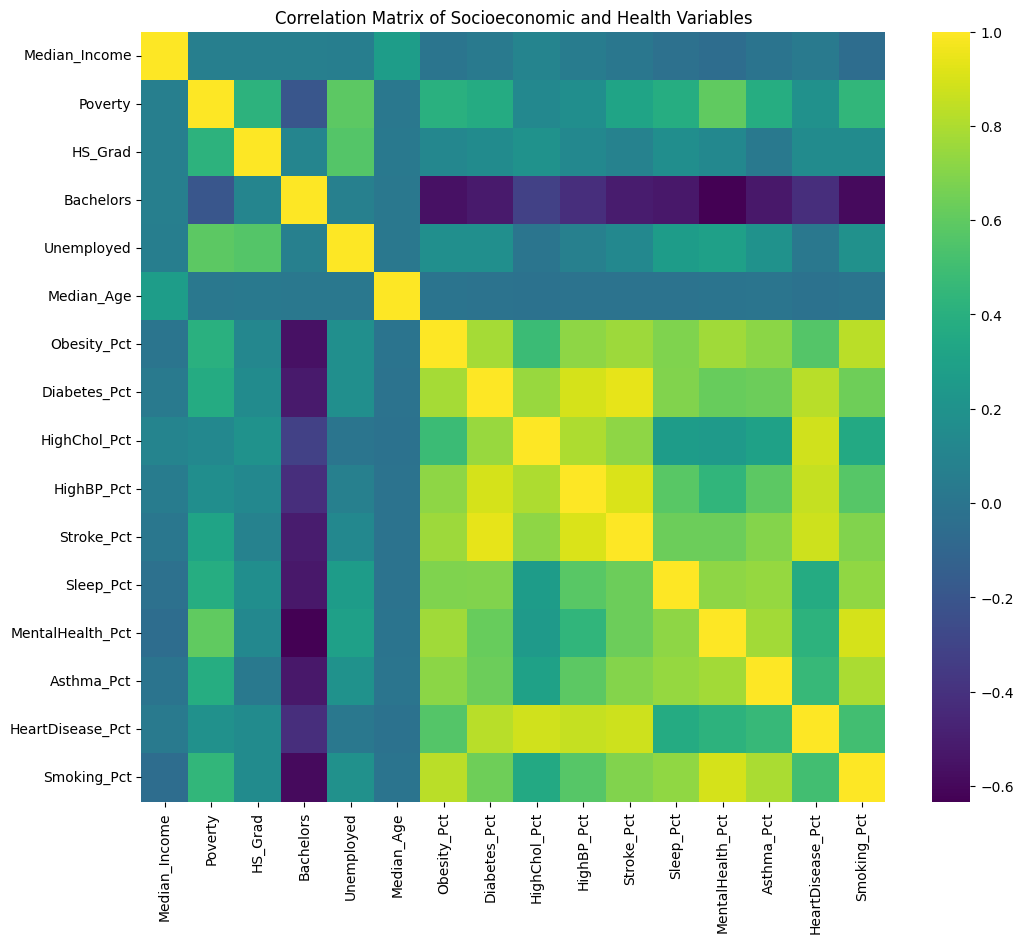

In [47]:
#Bivariate Analysis

#Correlation Matrix

variables_to_compare = [
    #socioeconomic variables first
    'Median_Income',
    'Poverty',
    'HS_Grad',
    'Bachelors',
    'Unemployed',
    'Median_Age',
    'Obesity_Pct',
    'Diabetes_Pct',
    'HighChol_Pct',
    'HighBP_Pct',
    'Stroke_Pct',
    'Sleep_Pct',
    'MentalHealth_Pct',
    'Asthma_Pct',
    'HeartDisease_Pct',
    'Smoking_Pct'
]

selected_data = merged_df[variables_to_compare]
corr_matrix = selected_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.title('Correlation Matrix of Socioeconomic and Health Variables')
plt.show()

Darker means stronger negative correlation, lighter means stronger positive correlation.

We can pick out interesting pairs from this heat map and then create scatter plots. Also, use this to generate hypotheses maybe.

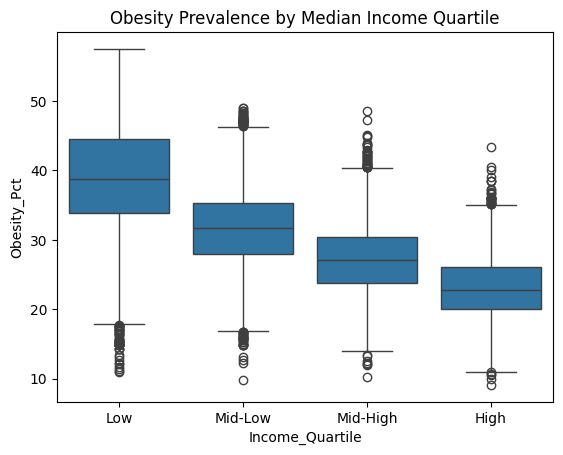

In [48]:
#Some grouped analysis

#Began by grouping median income into different income quartiles

merged_df['Income_Quartile'] = pd.qcut(merged_df['Median_Income'], 4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
sns.boxplot(data=merged_df, x='Income_Quartile', y='Obesity_Pct')
plt.title('Obesity Prevalence by Median Income Quartile')
plt.show()

Here we see that as income quartile increases, average obesity prevalence decreases (a clear relationship).

Can also get some hypotheses through this.

In [50]:
#i tried a chloropleth map but im not sure if this will help a lot

# pip install geopandas pygris
# pip install mapclassify


#creating GEOID column that is a combo of STATE FIPS, County FIPS, and Tract FIPS


merged_df['State_FIPS'] = merged_df['State_FIPS'].astype(str).str.zfill(2)
merged_df['County_FIPS'] = merged_df['County_FIPS'].astype(str).str.zfill(3)
merged_df['Tract_FIPS'] = merged_df['Tract_FIPS'].astype(str).str.zfill(6)

merged_df['GEOID'] = merged_df['State_FIPS'] + merged_df['County_FIPS'] + merged_df['Tract_FIPS']

merged_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Population2010,Obesity_Pct,Diabetes_Pct,HighChol_Pct,...,HighChol_Count,HighBP_Count,Stroke_Count,Sleep_Count,MentalHealth_Count,Asthma_Count,HeartDisease_Count,Smoking_Count,Income_Quartile,GEOID
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,06037206032,5275,29.5,15.5,38.3,...,2020.0,1672.0,211.0,2052.0,791.0,448.0,364.0,823.0,Low,06037206032
1,CA,Pasadena,656000,6037462001,0656000-06037462001,06037462001,3974,32.0,11.6,31.8,...,1264.0,1077.0,127.0,1598.0,624.0,374.0,191.0,707.0,Mid-Low,06037462001
2,CA,Fullerton,628000,6059011504,0628000-06059011504,06059011504,5473,18.7,4.6,21.1,...,1155.0,744.0,66.0,1828.0,772.0,504.0,115.0,728.0,Low,06059011504
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,9.2,33.9,...,1143.0,957.0,91.0,1176.0,455.0,314.0,182.0,691.0,Mid-High,48183000401
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,8.7,34.6,...,1472.0,1187.0,123.0,1310.0,502.0,391.0,255.0,706.0,Mid-Low,55025002200


In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pygris import tracts # for census shapes

#can changes by state we are analyzing
geo_tracts = tracts(state='TX', cb=True, year=2021)

#merging with the geographic data
map_df = geo_tracts.merge(merged_df, on='GEOID', how='left')

Using FIPS code '48' for input 'TX'
HTTP download failed, trying FTP as fallback...


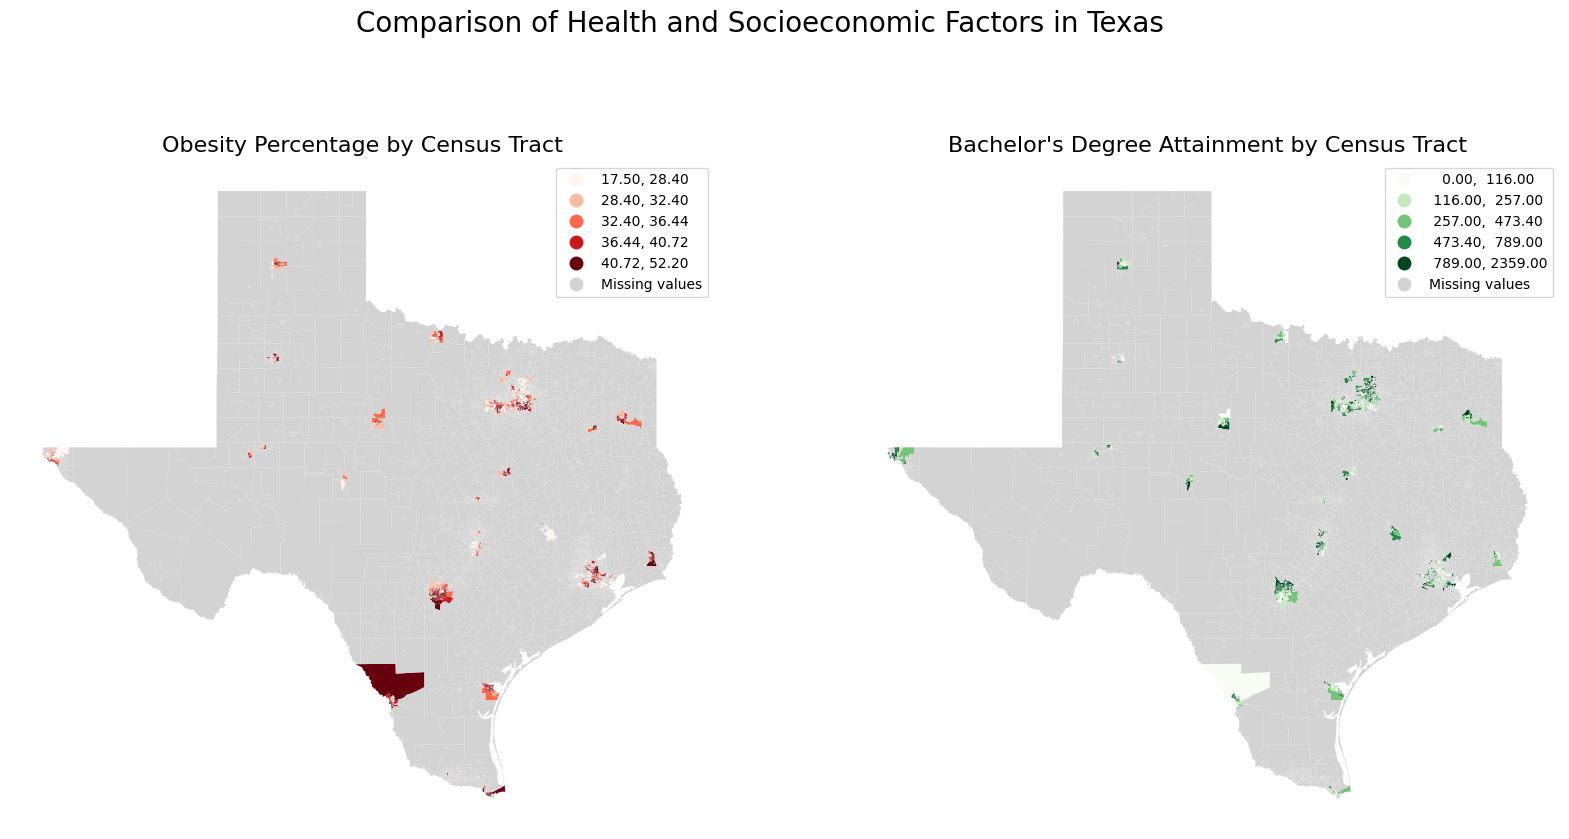

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# map 1: obesity_pct
map_df.plot(column='Obesity_Pct',
            ax=axes[0],
            legend=True,
            cmap='Reds', # red for negative health
            scheme='quantiles',
            k=5,
            missing_kwds={
                "color": "lightgrey",
                "label": "Missing values",
            })
axes[0].set_title('Obesity Percentage by Census Tract', fontsize=16)
axes[0].set_axis_off()

# map 2: bachelors
map_df.plot(column='Bachelors',
            ax=axes[1],
            legend=True,
            cmap='Greens', # green bc positive socioeconomic factor
            scheme='quantiles',
            k=5,
            missing_kwds={
                "color": "lightgrey",
                "label": "Missing values",
            })
axes[1].set_title("Bachelor's Degree Attainment by Census Tract", fontsize=16)
axes[1].set_axis_off()

fig.suptitle('Comparison of Health and Socioeconomic Factors in Texas', fontsize=20)

plt.show()

Looking for inverse relationships, we can see that one area with dark red (high obesity) corresponds to the lightest green area (low bachelor's degrees) on the other map.

We can pinpoint hotspots of low bachelors attainment, and specify if they are urban areas or rural areas or smth.

Look for anomalies like low obesity and low bachelors and vice versa.